# Regional MOM6 CPI

- regional MOM6 historical run monthly data is used
- Using the entire historical run period for better climatology (1993-2019)

## Determine the Cold Pool Index (CPI)
- define the Cold Pool Domain
    - MAB domain and between 38N-41.5N and between 75W-68.5W
    - between 20m to 200m isobath
    - average bottom temperature was cooler than 10°C (and > 6?) between June and September from 1959 to 2022
    - slicing off north of 41N or west of 70W? (southern flank of Georges Bank)

## CPI calculation 

In [1]:
import xarray as xr
import numpy as np
from mom6.mom6_module import mom6_io

### MOM6 IO

In [4]:
hist_run = mom6_io.MOM6Historical(
    var='tob',
    data_relative_dir='hist_run/',
    static_relative_dir='static/',
    grid='raw',
    source='local')

In [5]:
ds_data = hist_run.get_all()

In [7]:
ds_data

<xarray.Dataset> Size: 914MB
Dimensions:       (xh: 775, yh: 845, time: 324, xq: 776, yq: 846, nv: 2)
Coordinates: (12/14)
  * xh            (xh) float64 6kB -98.0 -97.92 -97.84 ... -36.24 -36.16 -36.08
  * yh            (yh) float64 7kB 5.273 5.352 5.432 5.511 ... 51.9 51.91 51.93
  * time          (time) datetime64[ns] 3kB 1993-01-16T12:00:00 ... 2019-12-1...
  * xq            (xq) float64 6kB -98.04 -97.96 -97.88 ... -36.2 -36.12 -36.04
  * yq            (yq) float64 7kB 5.233 5.312 5.392 5.472 ... 51.9 51.92 51.94
    geolon        (yh, xh) float32 3MB ...
    ...            ...
    geolat_c      (yq, xq) float32 3MB ...
    geolon_u      (yh, xq) float32 3MB ...
    geolat_u      (yh, xq) float32 3MB ...
    geolon_v      (yq, xh) float32 3MB ...
    geolat_v      (yq, xh) float32 3MB ...
  * nv            (nv) float64 16B 1.0 2.0
Data variables: (12/22)
    areacello     (yh, xh) float32 3MB ...
    deptho        (yh, xh) float32 3MB ...
    sftof         (yh, xh) float32 3MB ...
    Coriolis      (yq, xq) float32 3MB ...
    wet           (yh, xh) float32 3MB ...
    wet_c         (yq, xq) float32 3MB ...
    ...            ...
    areacello_bu  (yq, xq) float32 3MB ...
    average_DT    (time) timedelta64[ns] 3kB dask.array<chunksize=(324,), meta=np.ndarray>
    average_T1    (time) datetime64[ns] 3kB dask.array<chunksize=(324,), meta=np.ndarray>
    average_T2    (time) datetime64[ns] 3kB dask.array<chunksize=(324,), meta=np.ndarray>
    time_bnds     (time, nv) datetime64[ns] 5kB dask.array<chunksize=(324, 2), meta=np.ndarray>
    tob           (time, yh, xh) float32 849MB dask.array<chunksize=(22, 225, 206), meta=np.ndarray>
Attributes:
    NumFilesInSet:  1
    title:          NWA12_MOM6_v1.0
    grid_type:      regular
    grid_tile:      N/A

### 20~200 meter mask (MOM6)
based on bathymatry

In [9]:
da_mask_depth = ds_data.deptho.where((ds_data.deptho>20.)&(ds_data.deptho<200.),other=np.nan)

In [10]:
da_mask_depth = xr.where(da_mask_depth.notnull(),x=1,y=np.nan)

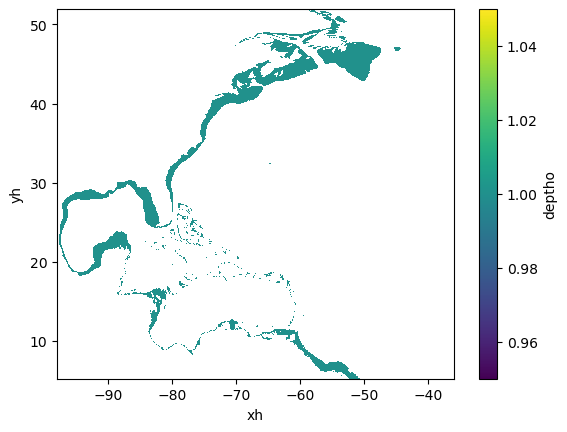

In [11]:
da_mask_depth.plot()

### Average of bottom temperature mask (MOM6)
- during June-September
- annual mean during June-September
- climatology long-term mean
- long-term mean lower than 10 degC

In [12]:
da_bottomT_Jun2Sep = ds_data.tob.where((ds_data['time.month']>=6)&(ds_data['time.month']<=9),drop=True)
da_bottomT_mon_ltm = da_bottomT_Jun2Sep.groupby(da_bottomT_Jun2Sep['time.month']).mean(dim='time').compute()
da_bottomT_ann_ltm = da_bottomT_Jun2Sep.groupby(da_bottomT_Jun2Sep['time.year']).mean(dim='time').mean(dim='year').compute()

In [13]:
da_mask_bottomT_mon = xr.where(da_bottomT_mon_ltm<10, x=1, y=np.nan)
da_mask_bottomT_ann = xr.where(da_bottomT_ann_ltm<10, x=1, y=np.nan)

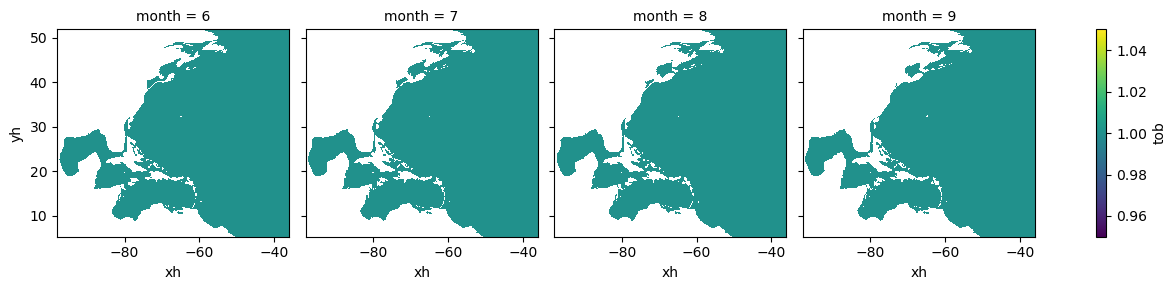

In [14]:
da_mask_bottomT_mon.plot(col='month')

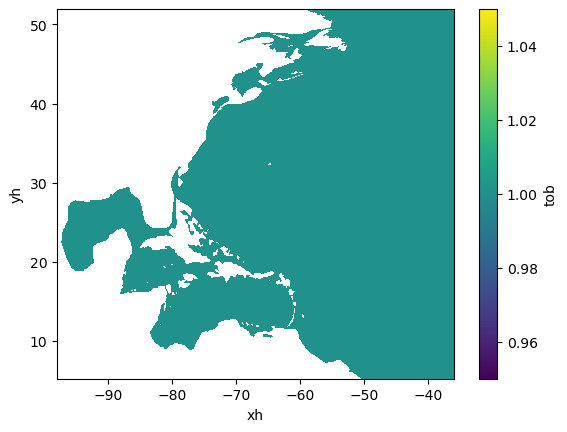

In [15]:
da_mask_bottomT_ann.plot()

### MAB with regional crop (MOM6)
- MAB
- regional crop

In [18]:
da_mask = mom6_io.MOM6Static.get_regionl_mask('masks/')['MAB']

In [20]:
da_mask

<xarray.DataArray 'MAB' (yh: 845, xh: 775)> Size: 5MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    geolat   (yh, xh) float32 3MB ...
    geolon   (yh, xh) float32 3MB ...
  * xh       (xh) float64 6kB -98.0 -97.92 -97.84 ... -36.24 -36.16 -36.08
  * yh       (yh) float64 7kB 5.273 5.352 5.432 5.511 ... 51.88 51.9 51.91 51.93

In [23]:
da_mask.geolon

<xarray.DataArray 'geolon' (yh: 845, xh: 775)> Size: 3MB
array([[-98.      , -97.92001 , -97.84    , ..., -36.23999 , -36.160004,
        -36.079987],
       [-98.      , -97.92001 , -97.84    , ..., -36.23999 , -36.160004,
        -36.079987],
       [-98.      , -97.92001 , -97.84    , ..., -36.23999 , -36.160004,
        -36.079987],
       ...,
       [-98.43506 , -98.359344, -98.28366 , ..., -37.337585, -37.25409 ,
        -37.170563],
       [-98.43863 , -98.362976, -98.28732 , ..., -37.347107, -37.26358 ,
        -37.180054],
       [-98.44226 , -98.36664 , -98.291016, ..., -37.35669 , -37.273132,
        -37.189545]], dtype=float32)
Coordinates:
    geolat   (yh, xh) float32 3MB 5.273 5.273 5.273 5.273 ... 58.15 58.16 58.16
    geolon   (yh, xh) float32 3MB -98.0 -97.92 -97.84 ... -37.36 -37.27 -37.19
  * xh       (xh) float64 6kB -98.0 -97.92 -97.84 ... -36.24 -36.16 -36.08
  * yh       (yh) float64 7kB 5.273 5.352 5.432 5.511 ... 51.88 51.9 51.91 51.93
Attributes:
    units:         degrees_east
    long_name:     Longitude of tracer (T) points
    cell_methods:  time: point

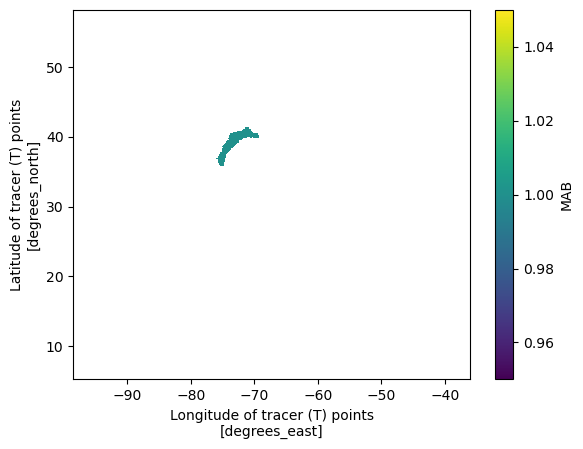

In [21]:
da_mask.plot(x='geolon',y='geolat')

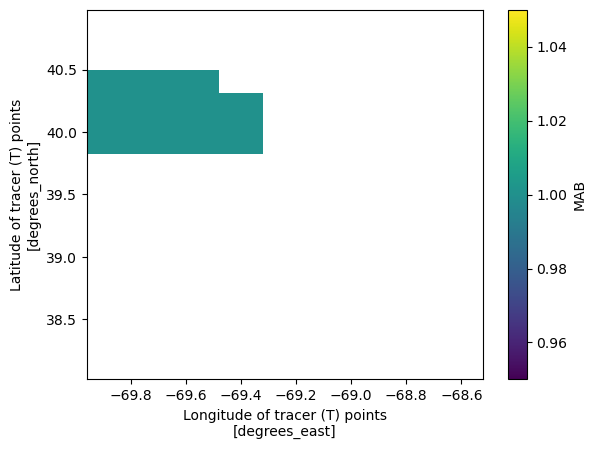

In [22]:
da_mask_crop = (da_mask
.where(
    (da_mask.geolat>38)&
    (da_mask.geolat<41.5)&
    (da_mask.geolon<-68.5)&
    (da_mask.geolon>-75),
    drop=True
).where(
    (da_mask.geolat<41)&
    (da_mask.geolon>-70),
    drop=True
))
da_mask_crop.plot(x='geolon',y='geolat')

In [24]:
da_mask_total_mon = da_mask_crop*da_mask_bottomT_mon*da_mask_depth
da_mask_total_ann = da_mask_crop*da_mask_bottomT_ann*da_mask_depth

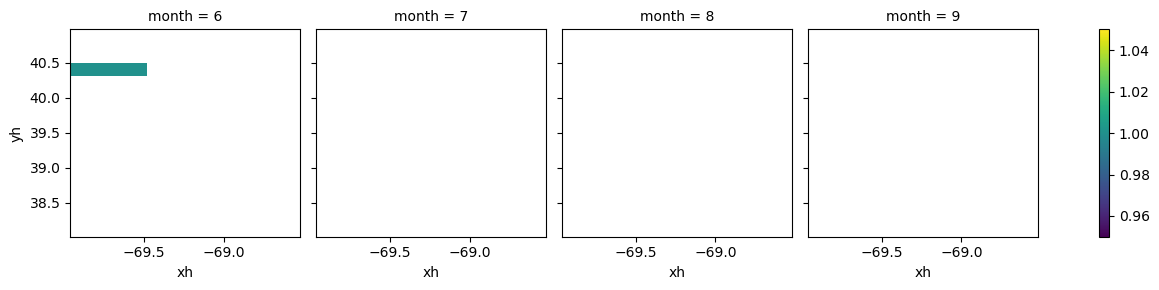

In [25]:
da_mask_total_mon.plot(col='month')

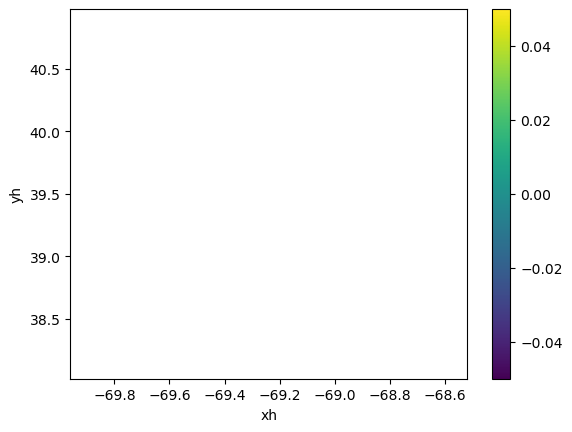

In [26]:
da_mask_total_ann.plot()

## MOM6 not working
the combined mask has zero grid. using the GLORYS mask instead

### Glorys IO

In [27]:
glorys_file = '/Projects/GLORYS/Monthlies/monolevel/bottomT.mon.mean.199301-202012.nc'
glorys_static_file = '/Projects/GLORYS/Statics/GLO-MFC_001_030_mask_bathy.nc'
ds = xr.open_mfdataset([glorys_file,glorys_static_file],chunks={'time':1})
ds = ds.drop_vars('mask')

In [28]:
ds

<xarray.Dataset> Size: 24GB
Dimensions:     (longitude: 4320, latitude: 2041, time: 336, depth: 50)
Coordinates:
  * longitude   (longitude) float32 17kB 0.0 0.08333 0.1667 ... 359.8 359.9
  * latitude    (latitude) float32 8kB -80.0 -79.92 -79.83 ... 89.83 89.92 90.0
  * time        (time) datetime64[ns] 3kB 1993-01-16T12:00:00 ... 2020-12-16T...
  * depth       (depth) float32 200B 0.494 1.541 2.646 ... 5.275e+03 5.728e+03
Data variables:
    bottomT     (time, latitude, longitude) float64 24GB dask.array<chunksize=(1, 2041, 4320), meta=np.ndarray>
    deptho      (latitude, longitude) float32 35MB dask.array<chunksize=(2041, 4320), meta=np.ndarray>
    deptho_lev  (latitude, longitude) float32 35MB dask.array<chunksize=(2041, 4320), meta=np.ndarray>
Attributes: (12/14)
    title:                         Monthly mean fields for product GLOBAL_REA...
    references:                    http://marine.copernicus.eu
    credit:                        E.U. Copernicus Marine Service Information...
    licence:                       http://marine.copernicus.eu/services-portf...
    contact:                       servicedesk.cmems@mercator-ocean.eu
    producer:                      CMEMS - Global Monitoring and Forecasting ...
    ...                            ...
    area:                          GLOBAL
    product:                       GLOBAL_REANALYSIS_001_030
    dataset:                       global-reanalysis-001-030-monthly
    source:                        MERCATOR GLORYS12V1
    product_user_manual:           http://marine.copernicus.eu/documents/PUM/...
    quality_information_document:  http://marine.copernicus.eu/documents/QUID...

### 20~200 meter mask (Glorys)
based on bathymatry

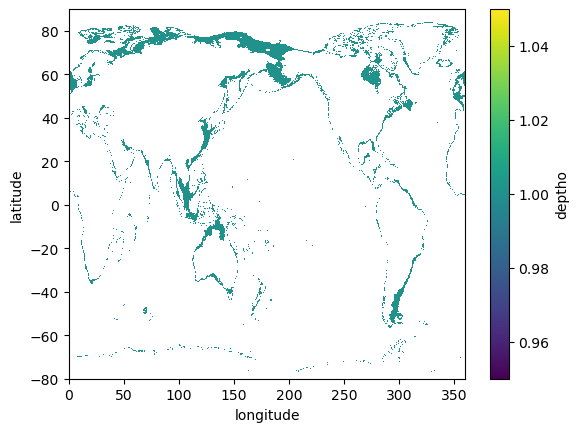

In [29]:
da_mask_depth = ds.deptho.where((ds.deptho>20.)&(ds.deptho<200.),other=np.nan)
da_mask_depth = xr.where(da_mask_depth.notnull(),x=1,y=np.nan)
da_mask_depth.plot()

### Average of bottom temperature mask (Glorys)
- during June-September
- annual mean during June-September
- climatology long-term mean
- long-term mean lower than 10 degC

In [30]:
da_bottomT_Jun2Sep = ds.bottomT.where((ds['time.month']>=6)&(ds['time.month']<=9),drop=True)
da_bottomT_mon_ltm = da_bottomT_Jun2Sep.groupby(da_bottomT_Jun2Sep['time.month']).mean(dim='time').compute()
da_bottomT_ann_ltm = da_bottomT_Jun2Sep.groupby(da_bottomT_Jun2Sep['time.year']).mean(dim='time').mean(dim='year').compute()

In [31]:
da_mask_bottomT_mon = xr.where(da_bottomT_mon_ltm<10, x=1, y=np.nan)
da_mask_bottomT_ann = xr.where(da_bottomT_ann_ltm<10, x=1, y=np.nan)

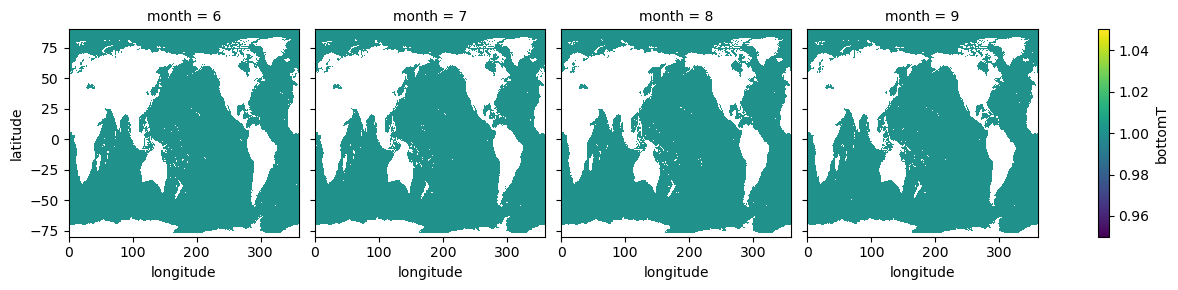

In [32]:
da_mask_bottomT_mon.plot(col='month')

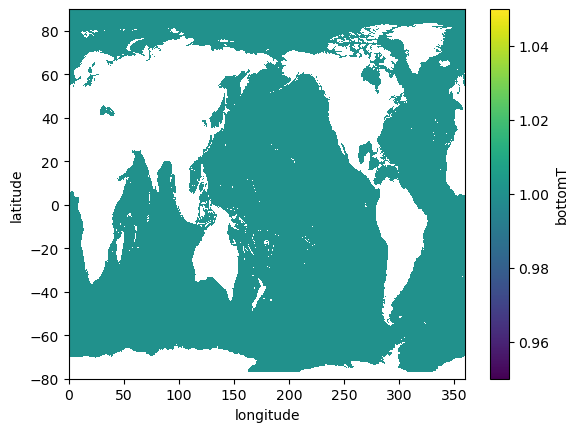

In [33]:
da_mask_bottomT_ann.plot()

### MAB with regional crop from MOM6 to Glorys
- MAB
- remap to GLORYS
- regional crop

In [34]:
ds_mask = mom6_io.MOM6Static.get_regionl_mask('masks/')

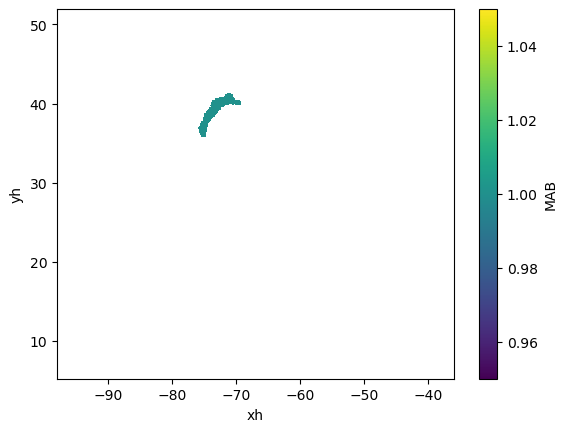

In [37]:
ds_mask['MAB'].plot()

In [35]:
# regrid the mask to GLORYS
import xesmf as xe

# use xesmf to create regridder 
# !!!! regridded only suited for geolon and geolat to x and y
regridder = xe.Regridder(ds_mask.rename({'geolon':'lon','geolat':'lat'}), ds, "bilinear", unmapped_to_nan=True)


In [39]:
# perform regrid
# https://pangeo-xesmf.readthedocs.io/en/latest/notebooks/Masking.html#Adaptive-masking
da_mask_regrid = regridder(ds_mask['MAB'], skipna=True, na_thres=0.25).compute()

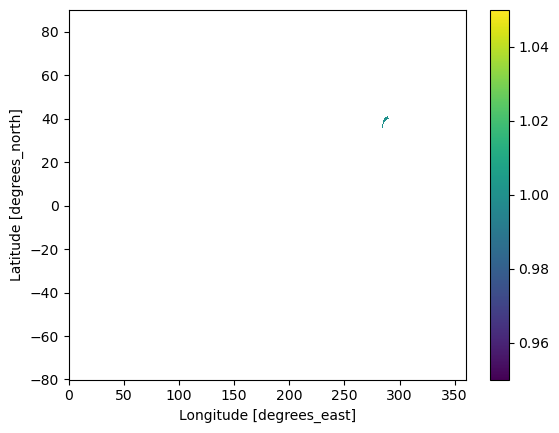

In [40]:
da_mask_regrid.plot()

In [41]:
da_mask_regrid_crop = (da_mask_regrid
    .where(
        (da_mask_regrid.latitude>=38)&
        (da_mask_regrid.latitude<=41.5)&
        (da_mask_regrid.longitude<=-68.5+360)&
        (da_mask_regrid.longitude>=-75+360),
        drop=True
    )
    .where(
        (da_mask_regrid.latitude<=41)&
        (da_mask_regrid.longitude>=-70+360),
        drop=True
    )
)

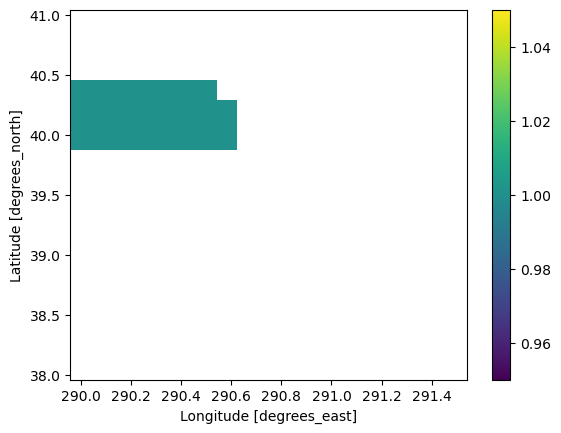

In [42]:
da_mask_regrid_crop.plot()

In [43]:
da_mask_total_mon = da_mask_regrid_crop*da_mask_bottomT_mon*da_mask_depth
da_mask_total_ann = da_mask_regrid_crop*da_mask_bottomT_ann*da_mask_depth

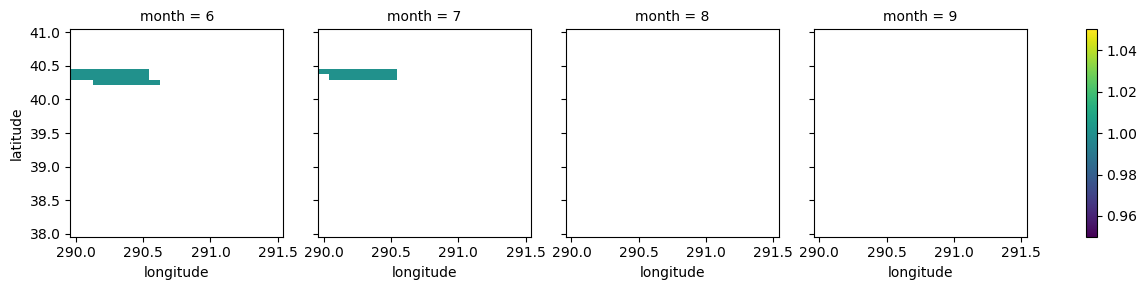

In [44]:
da_mask_total_mon.plot(col='month')

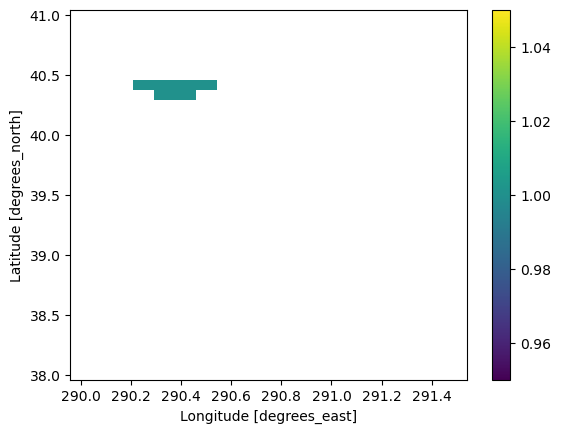

In [45]:
da_mask_total_ann.plot()

### Mask determined (GLORYS)

In [50]:
from mom6 import DATA_PATH
ds_cpi_mask = xr.Dataset()
ds_cpi_mask['CPI_mask'] = da_mask_total_ann
da_mask_total_ann.attrs['units'] = '1 over cold pool, fillvalue outside'
da_mask_total_ann.attrs['long_name'] = 'cold pool index mask based on only GLORYS'
ds_cpi_mask.attrs['desc'] = (
'Mask is on GLORYS grid. '+
'Cold pool index need to be calculated on the GLORYS grid. '+
'Following Ross et al., 2023 approach, user should regrid data to the mask grid.'
)
ds_cpi_mask.to_netcdf(f'{DATA_PATH}/masks/cpi_mask.nc')

### Calculate CPI using MOM6 data GLORYS mask

In [52]:
ds_data.tob

<xarray.DataArray 'tob' (time: 324, yh: 845, xh: 775)> Size: 849MB
dask.array<getitem, shape=(324, 845, 775), dtype=float32, chunksize=(22, 225, 206), chunktype=numpy.ndarray>
Coordinates:
  * xh       (xh) float64 6kB -98.0 -97.92 -97.84 ... -36.24 -36.16 -36.08
  * yh       (yh) float64 7kB 5.273 5.352 5.432 5.511 ... 51.88 51.9 51.91 51.93
  * time     (time) datetime64[ns] 3kB 1993-01-16T12:00:00 ... 2019-12-16T12:...
    geolon   (yh, xh) float32 3MB -98.0 -97.92 -97.84 ... -37.36 -37.27 -37.19
    geolat   (yh, xh) float32 3MB 5.273 5.273 5.273 5.273 ... 58.15 58.16 58.16
Attributes:
    units:          degC
    long_name:      Sea Water Potential Temperature at Sea Floor
    cell_methods:   area:mean yh:mean xh:mean time: mean
    cell_measures:  area: areacello
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_potential_temperature_at_sea_floor

In [53]:
regridder = xe.Regridder(ds_data.rename({'geolon':'lon','geolat':'lat'}), ds_cpi_mask, "bilinear", unmapped_to_nan=True)

In [54]:
da_tob_regrid = regridder(ds_data.tob)

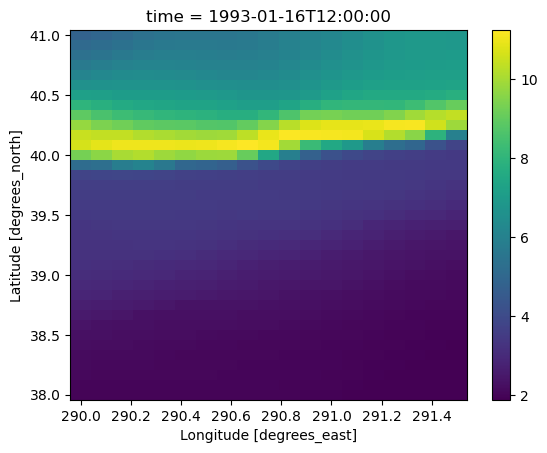

In [56]:
da_tob_regrid.isel(time=0).plot()

- calculate long-term mean and the month base time serie/annual mean based time series

In [57]:
da_bottomT_Jun2Sep = da_tob_regrid.where((da_tob_regrid['time.month']>=6)&(da_tob_regrid['time.month']<=9),drop=True)

In [59]:
da_bottomT_ann = da_bottomT_Jun2Sep.groupby(da_bottomT_Jun2Sep['time.year']).mean(dim='time')

In [61]:
da_bottomT_ann_ltm = da_bottomT_ann.mean('year')

- calculate the anomaly based on annual mean 
- apply mask (annual mask)

In [62]:
da_cpi_ann = ((da_bottomT_ann-da_bottomT_ann_ltm)*ds_cpi_mask['CPI_mask']).compute()

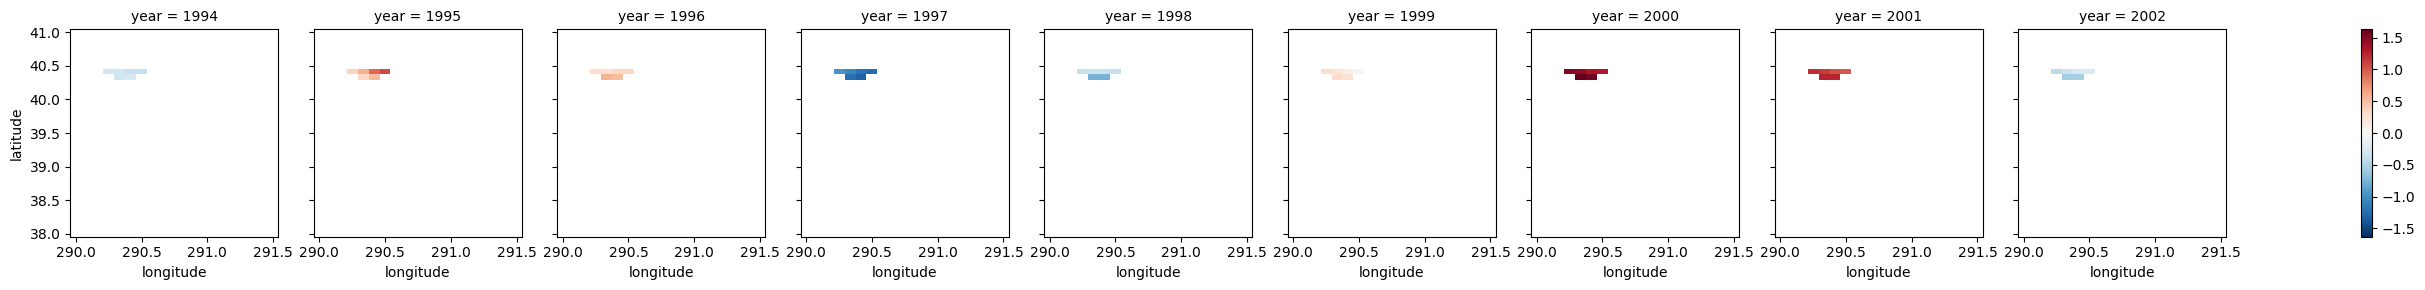

In [63]:
da_cpi_ann.isel(year=slice(1,10)).plot(col='year')

In [64]:
da_cpi_ann_mean = da_cpi_ann.mean(['latitude', 'longitude'])

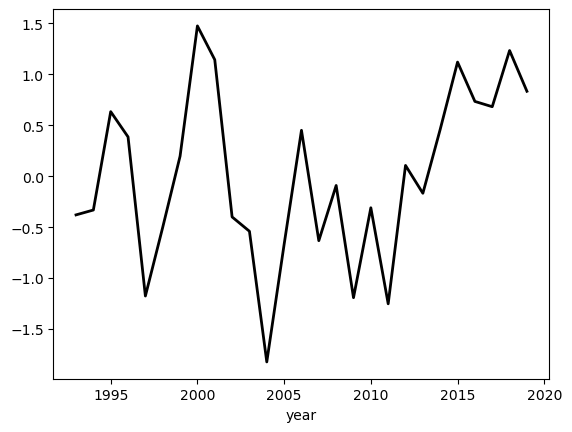

In [65]:
import matplotlib.pyplot as plt

da_cpi_ann_mean.plot(color='k',linewidth=2)

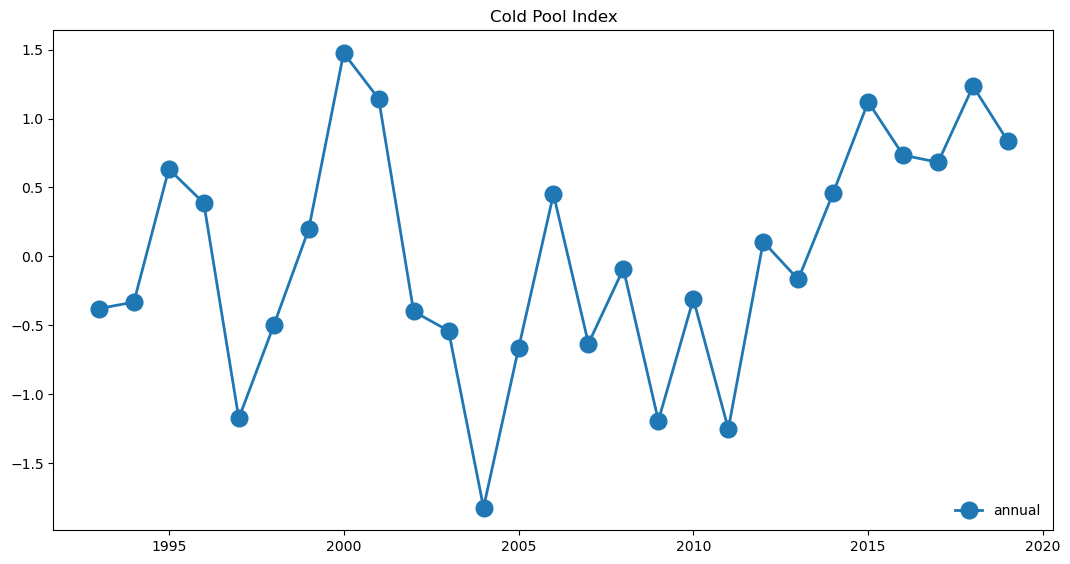

In [66]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=[10,5])
ax1 = fig.add_axes([0,0,1,1])
linewidth = 2
markersize = 12

ax1.plot(da_cpi_ann_mean.year,da_cpi_ann_mean.data,marker='o',linewidth=linewidth,markersize=markersize,label='annual')
ax1.set_title('Cold Pool Index')
ax1.legend(loc='lower right', frameon=False)

In [1]:
from mom6.mom6_module.mom6_io import MOM6Static, MOM6Historical
from mom6.mom6_module.mom6_indexes import ColdPoolIndex

location = 'local'
ds_mask = MOM6Static.get_cpi_mask('masks/')
ds_data = MOM6Historical('tob','hist_run/','static/','raw',location).get_all()

da_cpi_ann = ColdPoolIndex(
    ds_data,
    ds_mask,
    bottom_temp_name='tob',
    mask_name='CPI_mask'
).generate_index()

In [5]:
import numpy as np
np.abs(da_cpi_ann).sum()

<xarray.DataArray ()> Size: 8B
array(18.92449004)
Attributes:
    regrid_method:  bilinear

In [6]:
da_cpi_ann.max()

<xarray.DataArray ()> Size: 8B
array(1.47584972)
Attributes:
    regrid_method:  bilinear

In [7]:
da_cpi_ann.min()

<xarray.DataArray ()> Size: 8B
array(-1.82282283)
Attributes:
    regrid_method:  bilinear

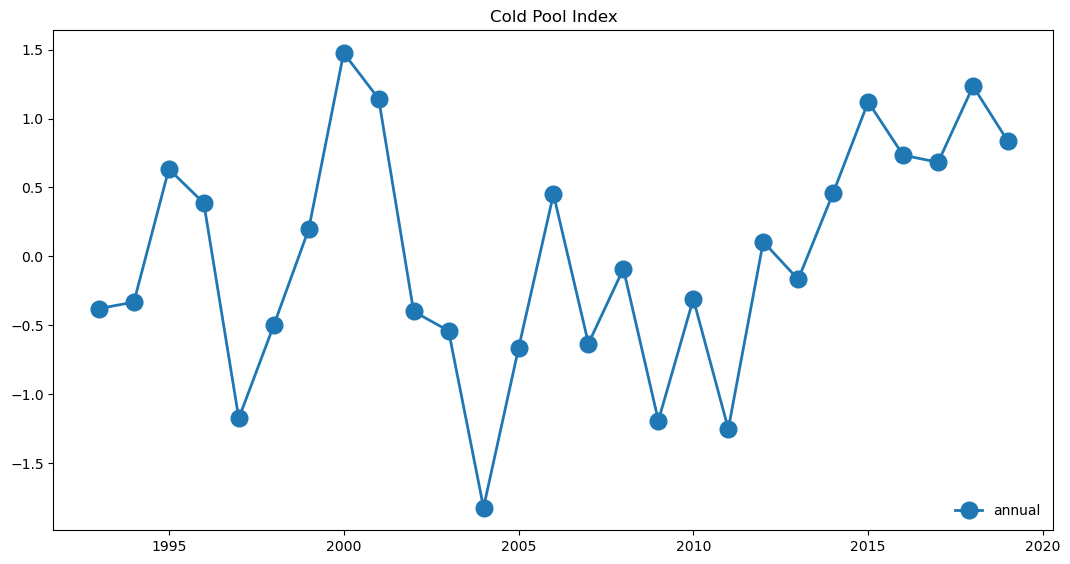

In [2]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=[10,5])
ax1 = fig.add_axes([0,0,1,1])
linewidth = 2
markersize = 12

ax1.plot(da_cpi_ann.year,da_cpi_ann.data,marker='o',linewidth=linewidth,markersize=markersize,label='annual')
ax1.set_title('Cold Pool Index')
ax1.legend(loc='lower right', frameon=False)